In [2]:
import pandas as pd
import numpy as np
path = "ECAI"

def get_intersection(v01, ve1, v02, ve2, max_weight=10):
    # handle division by zero masking out the positions where the denominator is zero
    denominator = ve2 - ve1
    if isinstance(denominator, np.ndarray):
        denominator[denominator == 0] = np.nan
    else:
        if denominator == 0:
            return np.nan
    wes = (v01 - v02) / denominator
    return np.round(wes[(wes >= 0) & (wes <= max_weight)], 2)


In [3]:
# Proper wes calculation

folder = lambda db, eff, we : f"/db{db}_effrate{eff}_we{we}_ECAI_new"
eff_rates = [0, 0.2, 0.4, 0.6, 0.8]
dbs = [1, 10, 1000]

we = np.zeros((len(eff_rates), len(dbs), 10))
we_std = np.zeros((len(eff_rates), len(dbs)))
we_median = np.zeros((len(eff_rates), len(dbs)))

for eff_rate in eff_rates:
    for db in dbs:
        if eff_rate == 0:
            continue
        
        unethical = pd.read_csv(path + folder(0, eff_rate, 0)*2  + "/mo_rewards.csv")
        unethical_np = unethical.to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)
        unethical_np[:, :, 1] = 0
        
        ethical = pd.read_csv(path + folder(db, eff_rate, 10)*2  + "/mo_rewards.csv")
        ethical_np = ethical.to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)

        wes = []
        for i in range(unethical_np.shape[0]):
            wag = []
            for ag in range(5):
                max_weight = 10
                w = get_intersection(unethical_np[i, ag, 0], unethical_np[i, ag, 1], ethical_np[i, ag, 0], ethical_np[i, ag, 1], max_weight=max_weight)
                if not np.isnan(w).all():
                    wag.append(w)
            if np.isnan(wag).all():
                continue
            wes.append(np.max(wag))
        if len(wes) == 0:
            continue

        we[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes)
        """we[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes).mean(axis=0).squeeze()
        we_std[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes).std(axis=0).squeeze()
        we_median[eff_rates.index(eff_rate), dbs.index(db)] = np.median(np.array(wes), axis=0).squeeze()"""
we[eff_rates.index(0.2), :].mean(axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'ECAI/db1000_effrate0.2_we10_ECAI_new/db1000_effrate0.2_we10_ECAI_new/mo_rewards.csv'

In [3]:
we[eff_rates.index(0.2), :].std(axis=1)

array([0.07955501, 0.06280127, 0.06679072])

In [4]:
np.median(we[eff_rates.index(0.4), :], axis=1)

array([2.405, 1.88 , 1.175])

In [5]:
# Print as latex row for table with standard deviation
for eff_rate in [0.2, 0.4, 0.6]:
    print(f"{int(eff_rate*100)}\% & ", end="")
    for db in [1, 10, 1000]:
        mean = we[eff_rates.index(eff_rate), dbs.index(db)].mean().round(2)
        std = we[eff_rates.index(eff_rate), dbs.index(db)].std().round(2)
        if db == 100:
            print(f"{mean} \\pm {std} ", end="")
        else:
            print(f"{mean} \\pm {std} & ", end="")
    print("\\\\")

20\% & 2.04 \pm 0.08 & 2.57 \pm 0.06 & 2.56 \pm 0.07 & \\
40\% & 2.45 \pm 0.15 & 1.84 \pm 0.09 & 1.17 \pm 0.08 & \\
60\% & 7.74 \pm 0.33 & 6.37 \pm 0.34 & 6.66 \pm 0.24 & \\


Agent, 		 ref[0],	 ref[1],	 unet[0],	 unet[1]
Agent 	0, 	-69.22, 	16.97, 	-39.23, 	0.0
Agent 	1, 	-55.11, 	18.73, 	-17.52, 	0.0
Agent 	2, 	-211.69, 	0.18, 	-494.15, 	0.0
Agent 	3, 	-237.32, 	0.44, 	-498.25, 	0.0
Agent 	4, 	-197.23, 	0.95, 	-498.91, 	0.0
[1.77]
[2.01]
[]
[]
[]


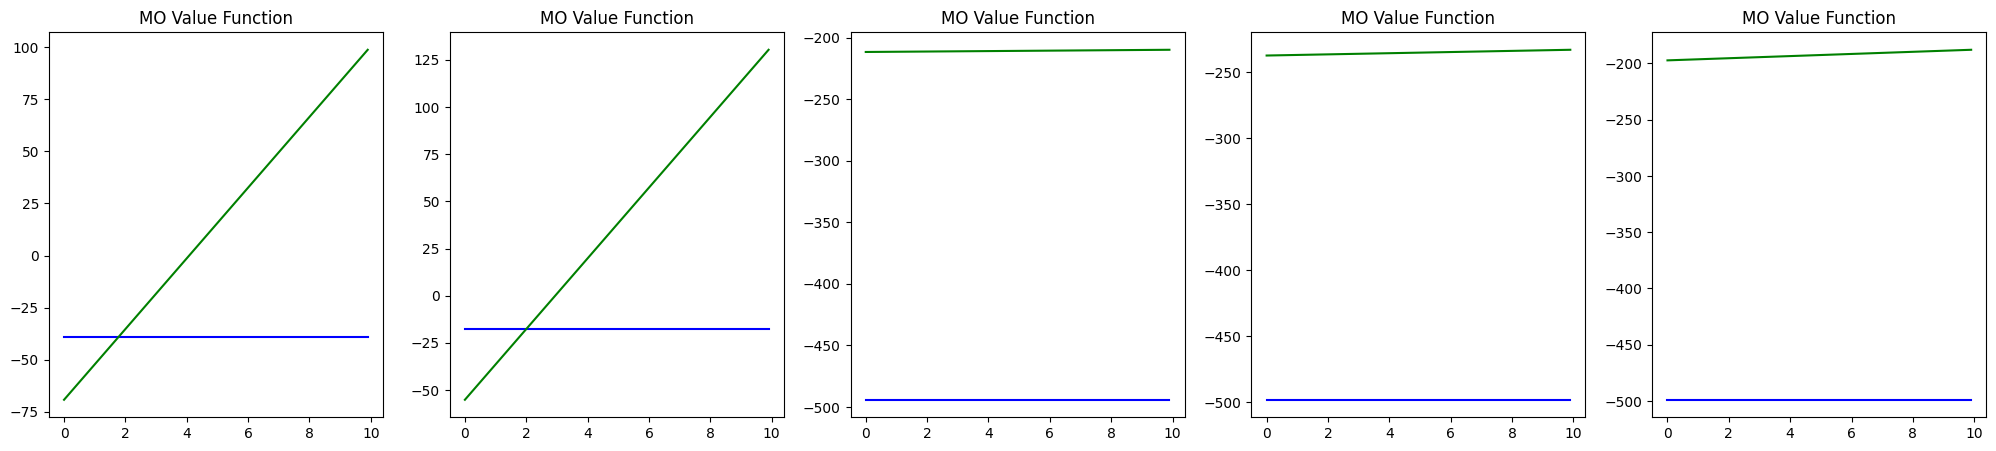

In [6]:
# Playground wes calculation
from value_vectors import *
import matplotlib.pyplot as plt
import  matplotlib
# matplotlib.use("Qt5Agg")

ref = policies[0.4][10]
unet = policies[0.4][0]
unet[:, 1] = 0 

fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

print("Agent, \t\t ref[0],\t ref[1],\t unet[0],\t unet[1]")
for i, ag in enumerate(range(5)):
    # Print lines like: Agent i, ref[0], ref[1], unet[0], unet[1]
    print(f"Agent \t{ag}, \t{ref[ag, 0]}, \t{ref[ag, 1]}, \t{unet[ag, 0]}, \t{unet[ag, 1]}")

for i, ag in enumerate(range(5)):
    axs[i].set_title("MO Value Function")
    axs[i].plot(x, np.dot(unet[ag], w), c="blue")
    axs[i].plot(x, np.dot(ref[ag], w), c="green")
    
wes = []
for ag in range(5):
    # Print intersecctions
    inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    print(inter)
    wes.append(inter)
plt.show()

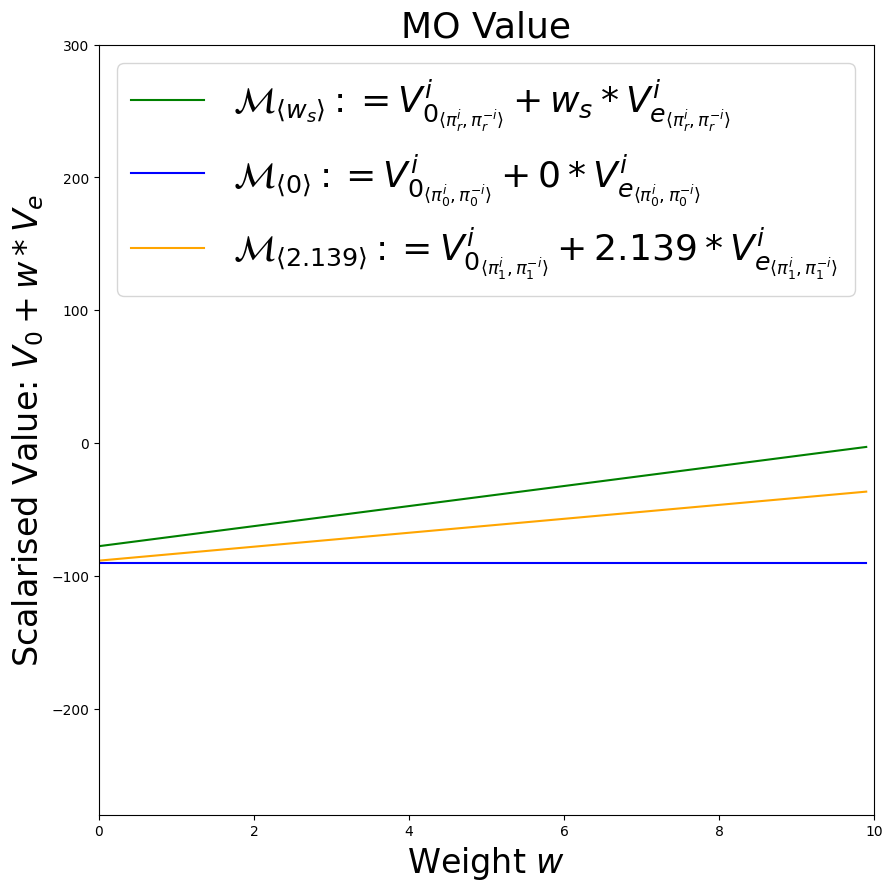

In [10]:
# Ploting for paper
from value_vectors import validations, policies
import matplotlib.pyplot as plt
import  matplotlib
#matplotlib.use("TkAgg")

ref = policies[0.8][10]
unet = policies[0.8][0]
middle = validations[0.8][10]

plt.figure(figsize=(10, 10))

ag = 1

step = 0.1
# for ag in mo_value_w10:
max_weight = 10

x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

plt.title("MO Value", fontsize=26)
plt.xlim(0, max_weight)
plt.ylim(-280, 300)
plt.plot(x, np.dot(ref[ag], w), c="green", label="$\mathcal{M}_{\langle w_s \\rangle} := V^i_{0_{\langle \pi^i_r, \pi^{-i}_r \\rangle}} + w_s * V^i_{e_{\langle \pi^i_r, \pi^{-i}_r \\rangle}}$ ")
plt.plot(x, np.dot(unet[ag], w), c="blue", label="$\mathcal{M}_{\langle 0 \\rangle} := V^i_{0_{\langle \pi^i_0, \pi^{-i}_0 \\rangle}} + 0 * V^i_{e_{\langle \pi^i_0, \pi^{-i}_0 \\rangle}}$")

plt.xlabel("Weight $w$", fontsize=24)
plt.ylabel("Scalarised Value: $V_0 + w * V_e$", fontsize=24)
if middle is not None:
    plt.plot(x, np.dot(middle[ag], w), c="orange", label="$\mathcal{M}_{\langle 2.139 \\rangle} := V^i_{0_{\langle \pi^i_1, \pi^{-i}_1 \\rangle}} + 2.139 * V^i_{e_{\langle \pi^i_1, \pi^{-i}_1 \\rangle}}$ ")

# Print intersecctions
#inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
#inter = [1, inter[0]]

# Plot a red dot on intersection
#plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, label="Intersection")

# Plot a black dashed line from the intersection to the x axis
#plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")

# add intersection to x ticks
#plt.xticks(list(plt.xticks()[0]) + [inter[1]])
plt.legend(fontsize=26, loc="upper left")
plt.show()

In [8]:
get_intersection(-180, 30, -100, 0)

TypeError: 'float' object is not subscriptable

In [4]:
def eval(eff_rate):
    db1 = pd.read_csv(path + folder(1, eff_rate, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    db10 = pd.read_csv(path + folder(10, eff_rate, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    db1000 = pd.read_csv(path + folder(1000, eff_rate, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    #middle = pd.read_csv(path + folder(1, 1, 10)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0]
    unet = pd.read_csv(path + folder(0, eff_rate, 0)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0].round(2)
    
    x = np.arange(0, max_weight, step)
    w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])
    
    n = int(eff_rate*5)
    fig, axs = plt.subplots(1, n, figsize=(8*n, 5))
    axs=[axs] if n == 1 else axs
    for i in range(n):
        axs[i].set_title("MO Value Function")
        axs[i].plot(x, np.dot(unet[i], w), c="blue", label=f"UNET:=${unet[i, 0]} + w_e \cdot {unet[i, 1]}$")
        axs[i].plot(x, np.dot(db1[i], w), c="red", label=f"DB=1:=${db1[i, 0]} + w_e \cdot {db1[i, 1]}$")
        axs[i].plot(x, np.dot(db10[i], w), c="magenta", label=f"DB=10:=${db10[i, 0]} + w_e \cdot {db10[i, 1]}$")
        axs[i].plot(x, np.dot(db1000[i], w), c="cyan", label=f"DB=1000:=${db1000[i, 0]} + w_e \cdot {db1000[i, 1]}$")
    
        if middle is not None:
            plt.plot(x, np.dot(middle[i], w), c="orange")
        axs[i].set_xlabel("Weight $w_e$")
        axs[i].set_ylabel("Scalarised Value")
        axs[i].set_xlim(0, max_weight)
        axs[i].set_ylim(-520, 300)
        axs[i].legend()
        
    wes_db1 = []
    wes_db10 = []
    wes_db1000 = []
    for ag in range(n):
        # Print intersecctions
        db1_inter = get_intersection(unet[ag, 0], unet[ag, 1], db1[ag, 0], db1[ag, 1], max_weight=max_weight)
        db10_inter = get_intersection(unet[ag, 0], unet[ag, 1], db10[ag, 0], db10[ag, 1], max_weight=max_weight)
        db1000_inter = get_intersection(unet[ag, 0], unet[ag, 1], db1000[ag, 0], db1000[ag, 1], max_weight=max_weight)
        print(f"Agent {ag}: {db1_inter} \t {db10_inter} \t {db1000_inter}")
        
        wes_db1.append(0 if len(db1_inter) == 0 else db1_inter[0])
        
        
            
    print(f"DB 1: \t\tMax: {np.max(wes_db1).round(2)}, Mean: {np.mean(wes_db1).round(2)}, Std: {np.std(wes_db1).round(2)}, Median: {np.median(wes_db1).round(2)}")
    print(f"DB 10: \t\tMax: {np.max(wes_db10).round(2)}, Mean: {np.mean(wes_db10).round(2)}, Std: {np.std(wes_db10).round(2)}, Median: {np.median(wes_db10).round(2)}")
    print(f"DB 1000: \tMax: {np.max(wes_db1000).round(2)}, Mean: {np.mean(wes_db1000).round(2)}, Std: {np.std(wes_db1000).round(2)}, Median: {np.median(wes_db1000).round(2)}")

    
    plt.show()
folder = lambda db, eff, we : f"/db{db}_effrate{eff}_we{we}_ECAI_new"

eff_rate = 0.8
eval(eff_rate)

FileNotFoundError: [Errno 2] No such file or directory: 'ECAI/db10_effrate0.8_we10_ECAI_new/db10_effrate0.8_we10_ECAI_new/mo_rewards.csv'

[1, 4.76]


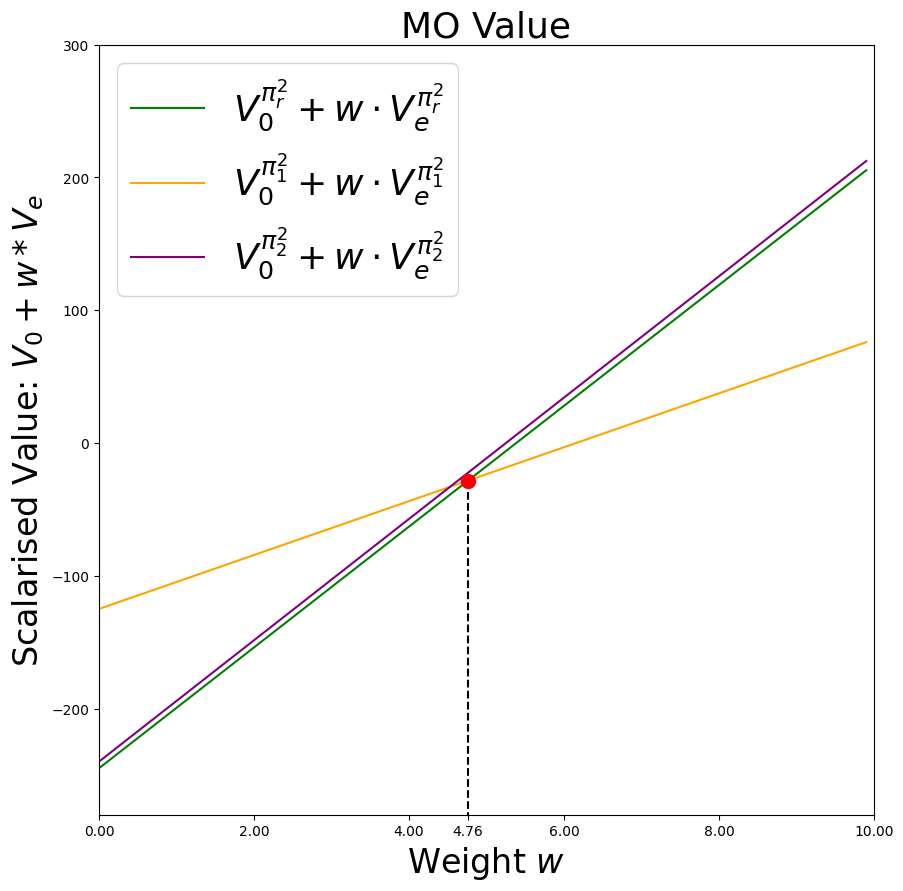

In [30]:
# Ploting for paper
from value_vectors import validations, policies
import matplotlib.pyplot as plt
import  matplotlib
#matplotlib.use("TkAgg")

middle = np.array([[-130, 15.92], [-125, 20.3]])
unet = None#np.array([[-90, 0.5], [-89, 0.6]])
ref = np.array([[-250, 40.5], [-245, 45.5]])
val = np.array([[-235, 41.2], [-240, 45.7]])

plt.figure(figsize=(10, 10))

ag = 1

step = 0.1
# for ag in mo_value_w10:
max_weight = 10

x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

plt.title("MO Value", fontsize=26)
plt.xlim(0, max_weight)
plt.ylim(-280, 300)

label = "$V_0^{\pi^"+ str(ag+1) +"_r} + w \cdot V_e^{\pi^"+ str(ag+1) +"_r}$"
plt.plot(x, np.dot(ref[ag], w), c="green", label=label)

if unet is not None:
    label = "$V_0^{\pi^"+ str(ag+1) +"_0} + w \cdot V_e^{\pi^"+ str(ag+1) +"_0}$"
    plt.plot(x, np.dot(unet[ag], w), c="blue", label=label)

plt.xlabel("Weight $w$", fontsize=24)
plt.ylabel("Scalarised Value: $V_0 + w * V_e$", fontsize=24)
if middle is not None:
    label = "$V_0^{\pi^"+ str(ag+1) +"_1} + w \cdot V_e^{\pi^"+ str(ag+1) +"_1}$"
    plt.plot(x, np.dot(middle[ag], w), c="orange", label=label)
    
if val is not None:
    label = "$V_0^{\pi^"+ str(ag+1) +"_2} + w \cdot V_e^{\pi^"+ str(ag+1) +"_2}$"
    plt.plot(x, np.dot(val[ag], w), c="purple", label=label)

tiks = list(plt.xticks()[0])

# Print intersecctions
if unet is not None:
    inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    inter = [1, inter[0]]
    tiks.append(inter[1])
    print(inter)
    
    # Plot a red dot on intersection
    plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)
    
    # Plot a black dashed line from the intersection to the x axis
    plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")

if middle is not None:
    inter = get_intersection(middle[ag, 0], middle[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    inter = [1, inter[0]]
    tiks.append(inter[1])
    print(inter)
    
    # Plot a red dot on intersection
    plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)

    # Plot a black dashed line from the intersection to the x axis
    plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")
    
#add intersection to x ticks
plt.xticks(tiks)
plt.legend(fontsize=26, loc="upper left")
plt.show()

[1, 4.0]
[1, 4.88]
[1, 3.47]
[1, 4.76]


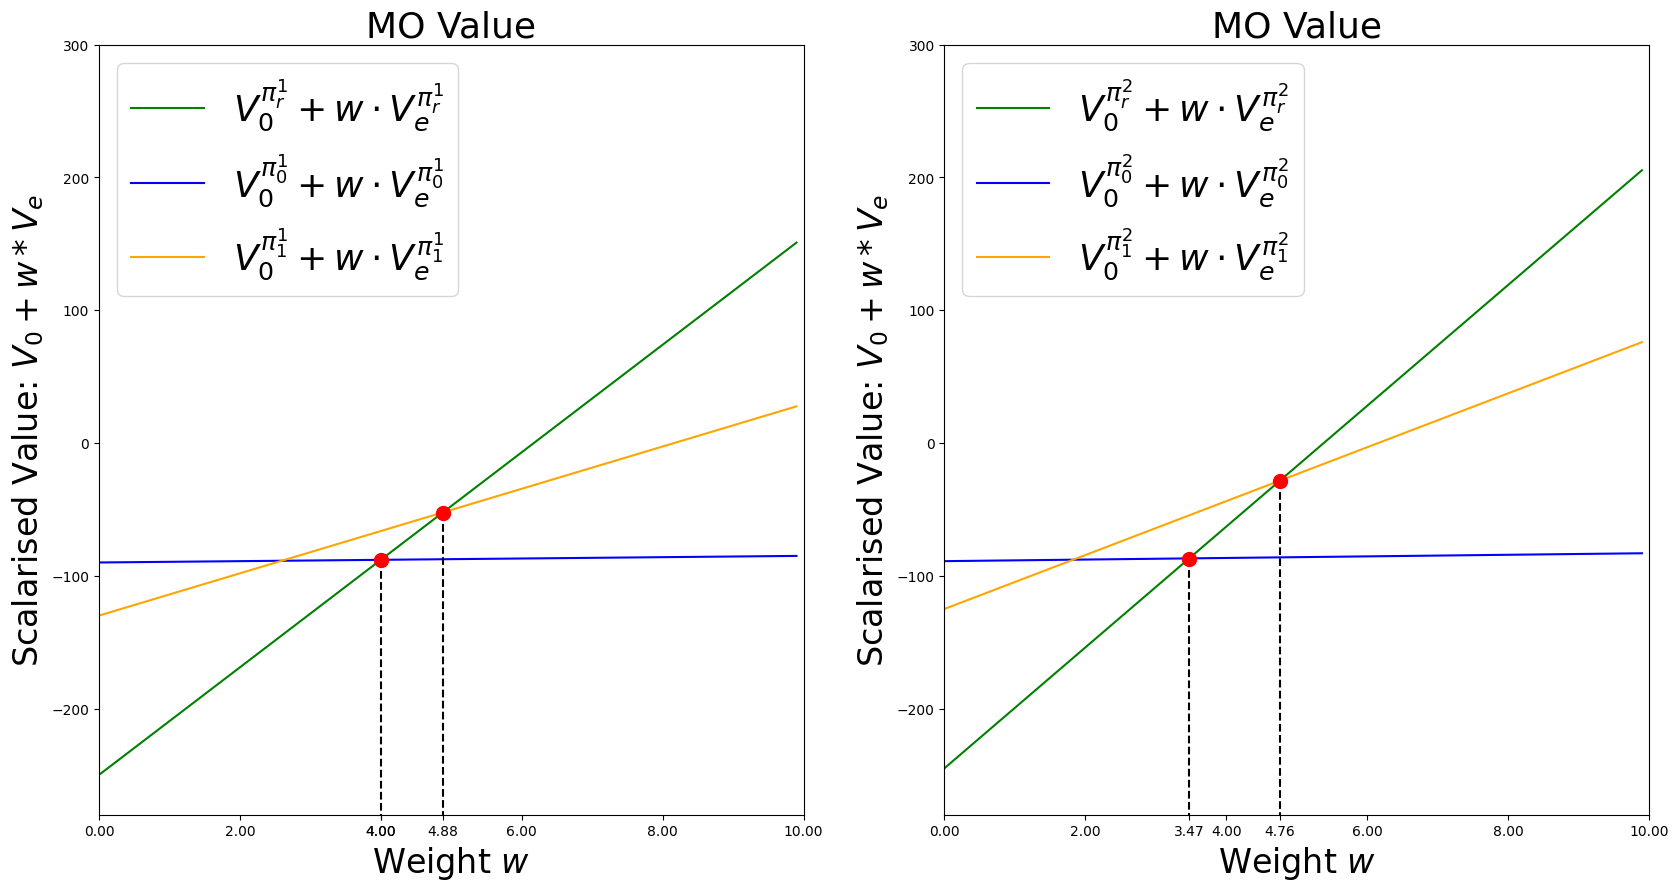

In [6]:
# Ploting for paper
from value_vectors import validations, policies
import matplotlib.pyplot as plt
import  matplotlib
#matplotlib.use("TkAgg")

middle = np.array([[-130, 15.92], [-125, 20.3]])
unet = np.array([[-90, 0.5], [-89, 0.6]])
ref = np.array([[-250, 40.5], [-245, 45.5]])
val = None#np.array([[-235, 41.2], [-240, 45.7]])

plt.subplots(1, 2, figsize=(20, 10))

for ag in range(2):
    plt.subplot(1, 2, ag+1)
    step = 0.1
    # for ag in mo_value_w10:
    max_weight = 10
    
    x = np.arange(0, max_weight, step)
    w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])
    
    plt.title("MO Value", fontsize=26)
    plt.xlim(0, max_weight)
    plt.ylim(-280, 300)
    
    label = "$V_0^{\pi^"+ str(ag+1) +"_r} + w \cdot V_e^{\pi^"+ str(ag+1) +"_r}$"
    plt.plot(x, np.dot(ref[ag], w), c="green", label=label)
    
    if unet is not None:
        label = "$V_0^{\pi^"+ str(ag+1) +"_0} + w \cdot V_e^{\pi^"+ str(ag+1) +"_0}$"
        plt.plot(x, np.dot(unet[ag], w), c="blue", label=label)
    
    plt.xlabel("Weight $w$", fontsize=24)
    plt.ylabel("Scalarised Value: $V_0 + w * V_e$", fontsize=24)
    if middle is not None:
        label = "$V_0^{\pi^"+ str(ag+1) +"_1} + w \cdot V_e^{\pi^"+ str(ag+1) +"_1}$"
        plt.plot(x, np.dot(middle[ag], w), c="orange", label=label)
        
    if val is not None:
        label = "$V_0^{\pi^"+ str(ag+1) +"_2} + w \cdot V_e^{\pi^"+ str(ag+1) +"_2}$"
        plt.plot(x, np.dot(val[ag], w), c="purple", label=label)
    
    tiks = list(plt.xticks()[0])
    
    # Print intersecctions
    if unet is not None:
        inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
        inter = [1, inter[0]]
        tiks.append(inter[1])
        print(inter)
        
        # Plot a red dot on intersection
        plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)
        
        # Plot a black dashed line from the intersection to the x axis
        plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")
    
    if middle is not None:
        inter = get_intersection(middle[ag, 0], middle[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
        inter = [1, inter[0]]
        tiks.append(inter[1])
        print(inter)
        
        # Plot a red dot on intersection
        plt.scatter(inter[1], np.dot(ref[ag], inter), c="red", s=100, zorder=10)
    
        # Plot a black dashed line from the intersection to the x axis
        plt.plot([inter[1], inter[1]], [np.dot(ref[ag], inter), -300], c="black", linestyle="--")
        
    #add intersection to x ticks
    plt.xticks(tiks)
    plt.legend(fontsize=26, loc="upper left")
plt.show()